# Week 3: Getting data—scraping and APIs.

This week is about getting data from the big ol' Internet, with the Wikipedia as our guinea pig. The main task today is to retrieve the Wikipedia pages of **all Marvel characters** using the MediaWiki **API**. There are three parts to this exercise.

* Learn the basics of how to retrieve data from Wiki sites using the MediaWiki API
* Download all Marvel character Wikipedia articles
* Explore the data

The data you acquire today, you will be working with for the remainder of the course. Try to get as far as possible, structure the data nicely and write your code so that it makes sense to you in the coming weeks.

Also, there's an **important practice** you should start getting used to—which matters when we grade assignments. 
1. Openly reflect on how you solve a problem. It can be code comments, or markup below/above the code cell, just as long as you share your thoughts. 
2. Comment on your results, discussing:
    * Whether they make sense
    * If they look somewhat as you expected, and if not, what the reasons for this difference may be
    * What—interesting or not—insight they reveal about the given system you analyze
    
    *Note: of course you can't always say something profound about every little thing, so rest assured, I will only expect explanations in your assignments when *it makes sense* that there should be one.*

**[Feedback](http://ulfaslak.com/vent)**

## Exercises

**Why use an API?** You could just go ahead and scrape the HTML from a Wikipedia page as simple as:

    import requests as rq
    rq.get("https://en.wikipedia.org/wiki/Batman").text
    
Well... to navigate data in XML format is not always easy. Therefore, MediaWiki offers its users direct use of its API. To load the MediaWiki markup using the API, one would do something like:

    rq.get("https://en.wikipedia.org/w/api.php?format=json&action=query&titles=Batman&prop=revisions&rvprop=content").json()
    
This returns a JSON object inside which you can find all sorts of information about the page, including the latest revision of the Batman page markup.

**Helpful code to display JSON object as a tree**

In [4]:
def print_json_tree(d, indent=0):
    """Print tree of keys in JSON object.
    
    Prints the different levels of nested keys in a JSON object. When there
    are no more dictionaries to key into, prints objects type and byte-size.

    Input
    -----
    d : dict
    """
    for key, value in d.items():
        print('    ' * indent + str(key), end=' ')
        if isinstance(value, dict):
            print(); print_json_tree(value, indent+1)
        else:
            print(":", str(type(d[key])).split("'")[1], "-", str(len(str(d[key]))))
            
# Example
import requests as rq
data = rq.get("https://en.wikipedia.org/w/api.php?format=json&action=query&titles=Batman&prop=revisions&rvprop=content").json()
print_json_tree(data)

batchcomplete : str - 0
warnings 
    main 
        * : str - 267
    revisions 
        * : str - 163
query 
    pages 
        4335 
            pageid : int - 4
            ns : int - 1
            title : str - 6
            revisions : list - 146962


### Part 0: Learn to access Wikipedia data with Python

Figure out how Wikipedia markup works. You'll need to know a bit about formatting of MediaWiki pages so that you can parse the markup that you retrieve from wikipedia. See http://www.mediawiki.org/wiki/Help:Formatting. In particular, look into how links work and how tables work and make sure you can answer the following questions.

>**Ex. 3.0.1**: How do you link to another Wikipedia page from within a Wikipedia-page, using the wikimedia markup? Write down a simple example that links to a specific section in another page.

In [ ]:
[[Computer#Specific section]]

> **Ex. 3.0.2**: What is the MediaWiki markup to create a simple table like the one below?

>| True Positive  | False Positive |
| -------------- |:--------------:|
| False Negative | True Negative  |

{| class="wikitable"
!True Positive
!False Positive
|-
|False Negative  
|True Negative
|}

> **Ex. 3.0.3**: Figure out how to download pages from Wikipedia. Familiarize yourself with [the API](http://www.mediawiki.org/wiki/API:Main_page) (there's a nice little [tutorial](https://www.mediawiki.org/wiki/API:Tutorial)) and learn how to extract the markup. The API query that returns the markup of the Batman page is:
    
>`api.php?format=json&action=query&titles=Batman&prop=revisions&rvprop=content`

>1. Explain the structure of this query. What are the parameters and arguments and what do they mean? What happens if you remove `rvprop=content`?
2. Download the Batman page data from the API. Extract the markup from the JSON object and save it to a file called "batman.txt".

1:
- `format=json` requests the output to be in json format. some other formats include `jsonfm, xml, xmlfm`. 
- `action=query` specifies that this is a query. 
- `titles=Batman` specifies that we are querying the title `Batman`. 
- If we want several titles, we can separate values with a pipe.
- `prop=revisions` means we want to request revision information. 
- `rvprop=content` specifies that we want the content of each revision slot.

2:


In [26]:
# extract the markup
markup = data['query']['pages']['4335']['revisions'][0]['*']

# save to file "batman.txt"

with open('batman.txt', 'w') as f:
    f.write(markup)

### Part 1: Get data (main part)

For a good part of this course we will be working with data from Wikipedia. Today, your objective is to crawl a large dataset with good and bad characters from the Marvel characters.

>**Ex. 3.1.1**: From the Wikipedia API, get a list of all Marvel superheroes and another list of all Marvel supervillains. Use 'Category:Marvel_Comics_supervillains' and 'Category:Marvel_Comics_superheroes' to get the characters in each category.
1. How many superheroes are there? How many supervillains?
2. How many characters are both heroes and villains? What is the Jaccard similarity between the two groups?

>*Hint: Google something like "get list all pages in category wikimedia api" if you're struggling with the query.*

In [88]:
def grab_supervillains():
    supervillain_dict = {}
    gcm_continue = ''
    query = 'https://en.wikipedia.org/w/api.php?action=query&format=json&generator=categorymembers&gcmtitle=Category:Marvel_Comics_supervillains&gcmlimit=max' 

    while True:
        full_query = query + '&gcmcontinue=' + gcm_continue if gcm_continue!='' else query
#         print(full_query)    

        villains_data = rq.get(full_query).json()

        #update the dict
        supervillain_dict.update(villains_data['query']['pages'])

#         print(len(supervillain_dict))

#         print(gcm_continue)

        # update gcm_continue key
        if 'continue' not in villains_data:
            break
        else:
            gcm_continue = villains_data['continue']['gcmcontinue']
            
    return supervillain_dict

def grab_superheroes():
    superhero_dict = {}
    gcm_continue = ''
    query = 'https://en.wikipedia.org/w/api.php?action=query&format=json&generator=categorymembers&gcmtitle=Category:Marvel_Comics_superheroes&gcmlimit=max'

    while True:
        full_query = query + '&gcmcontinue=' + gcm_continue if gcm_continue!='' else query
#         print(full_query)    

        heroes_data = rq.get(full_query).json()

        #update the dict
        superhero_dict.update(heroes_data['query']['pages'])

#         print(len(superhero_dict))

#         print(gcm_continue)

        # update gcm_continue key
        if 'continue' not in heroes_data:
            break
        else:
            gcm_continue = heroes_data['continue']['gcmcontinue']
            
    return superhero_dict

supervillains = grab_supervillains()
superheroes = grab_superheroes()

print('there are %d supervillains' % len(supervillains))
print('there are %d superheroes' % len(superheroes))

villains_set = set(supervillains.keys())
heroes_set = set(superheroes.keys())
intersect = villains_set & heroes_set
union = villains_set.union(heroes_set)

jaccard_index = len(intersect) / len(union)

print('the jaccard index of these two sets is %f' % jaccard_index)

there are 1098 supervillains
there are 851 superheroes
the jaccard index of these two sets is 0.084585


>**Ex. 3.1.2**: Using this list you now want to download all data you can about each character. However, because this is potentially Big Data, you cannot store it your computer's memory. Therefore, you have to store it in your harddrive somehow. 
* Create three folders on your computer, one for *heroes*, one for *villains*, and one for *ambiguous*.
* For each character, download the markup on their pages and save in a new file in the corresponding hero/villain/ambiguous folder.

>*Hint: Some of the characters have funky names. The first problem you may encounter is problems with encoding. To solve that you can call `.encode('utf-8')` on your markup string. Another problem you may encounter is that characters have a slash in their names. This, you should just replace with some other meaningful character.*

In [54]:
# ! mkdir heroes villains ambiguous

In [121]:
import re

true_villains = villains_set - intersect
true_heroes = heroes_set - intersect
ambiguous = intersect

print('there are %d true villains' % len(true_villains))
print('there are %d true heroes' % len(true_heroes))
print('there are %d ambiguous ppl' % len(ambiguous))

def download_villains():
    print('downloading villains', end='', flush=True)
    for villain in true_villains:
        query = 'https://www.wikipedia.org/w/api.php?action=query&format=json&prop=revisions&rvprop=content&pageids=' + villain

        data = rq.get(query).json()
        markup = data['query']['pages'][str(villain)]['revisions'][0]['*']
        title = re.sub('/','_',data['query']['pages'][str(villain)]['title'])

        with open('villains/' + title + '.txt', 'w') as f:
            f.write(markup)
            
        print('.', end='', flush=True)
    
    print('##### FINISHED DOWNLOADING VILLAINS #####')
        
def download_heroes():
    print('downloading heroes', end='', flush=True)
    for hero in true_heroes:
        query = 'https://www.wikipedia.org/w/api.php?action=query&format=json&prop=revisions&rvprop=content&pageids=' + hero

        data = rq.get(query).json()
        markup = data['query']['pages'][str(hero)]['revisions'][0]['*']
        title = re.sub('/','_',data['query']['pages'][str(hero)]['title'])
        
        with open('heroes/' + title + '.txt', 'w') as f:
            f.write(markup)
            
        print('.', end='', flush=True)
    
    print('##### FINISHED DOWNLOADING HEROES #####')
    
def download_ambiguous_peeps():
    print('downloading ambiguous characters', end='', flush=True)
    for ambiguous_peep in ambiguous:
        query = 'https://www.wikipedia.org/w/api.php?action=query&format=json&prop=revisions&rvprop=content&pageids=' + ambiguous_peep
        
        data = rq.get(query).json()
        markup = data['query']['pages'][str(ambiguous_peep)]['revisions'][0]['*']
        title = re.sub('/','_',data['query']['pages'][str(ambiguous_peep)]['title'])

        with open('ambiguous/' + title + '.txt', 'w') as f:
            f.write(markup)
            
        print('.', end='', flush=True)
    
    print('##### FINISHED DOWNLOADING AMBIGUOUS PEEPS #####')
        
download_villains()
download_heroes()
download_ambiguous_peeps()

there are 946 true villains
there are 699 true heroes
there are 152 ambiguous ppl
downloading villains..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

### Part 2: Explore data

#### Page lengths

>**Ex. 3.2.1**: Extract the length of the page of each character, and plot the distribution of this variable for each class (heroes/villains/ambiguous). Can you say anything about the popularity of characters in the Marvel universe based on your visualization?

>*Hint: The simplest thing is to make a probability mass function, i.e. a normalized histogram. Use `plt.hist` on a list of page lengths, with the argument `density=True`. Other distribution plots are fine too, though.*

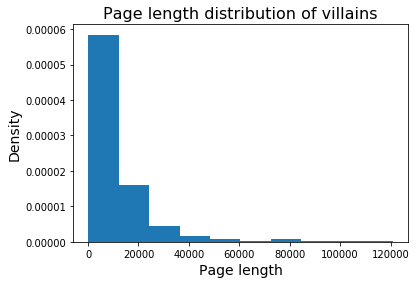

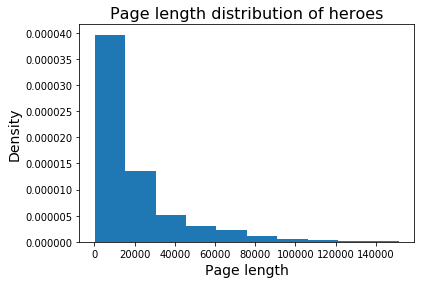

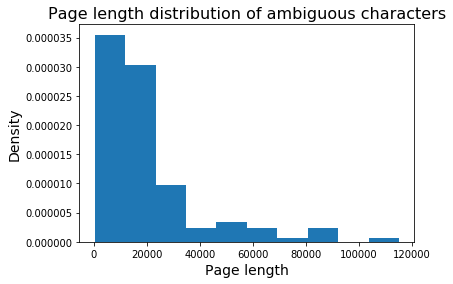

In [136]:
# villains
from os import listdir, getcwd
from matplotlib import pyplot as plt

def extract_char(path):
    with open(path, 'r') as f:
        return len(f.read())
        
def plot_villains():
    lengths = []
    for villain in listdir('villains/'):
        length = extract_char('villains/' + villain)
        lengths.append(length)
    
    # plot
    plt.figure()
    plt.title('Page length distribution of villains', fontsize=16)
    plt.ylabel('Density', fontsize=14)
    plt.xlabel('Page length', fontsize=14)
    plt.hist(lengths, density=True)
    plt.show()
    
    return lengths
  
        
def plot_heroes():
    lengths = []
    for hero in listdir('heroes/'):
        length = extract_char('heroes/' + hero)
        lengths.append(length)
    
    # plot
    plt.figure()
    plt.title('Page length distribution of heroes', fontsize=16)
    plt.ylabel('Density', fontsize=14)
    plt.xlabel('Page length', fontsize=14)
    plt.hist(lengths, density=True)
    plt.show()
    
    return lengths
    
            
def plot_ambiguous():
    lengths = []
    for ambi in listdir('ambiguous/'):
        length = extract_char('ambiguous/' + ambi)
        lengths.append(length)
    
    # plot
    plt.figure()
    plt.title('Page length distribution of ambiguous characters', fontsize=16)
    plt.ylabel('Density', fontsize=14)
    plt.xlabel('Page length', fontsize=14)
    plt.hist(lengths, density=True)
    plt.show()
    
    return lengths
        

villain_lengths = plot_villains()
hero_lengths = plot_heroes()
ambiguous_lengths = plot_ambiguous()

>**Ex. 3.2.2**: Find the 10 characters from each class with the longest Wikipedia pages. Visualize their page lengths with bar charts. Comment on the result.

the top 10 villains with the longest wikipedia pages are: 
	 Doctor Octopus
	 Norman Osborn
	 Loki (comics)
	 Vulture (Marvel Comics)
	 Lizard (comics)
	 Electro (Marvel Comics)
	 Venom (Marvel Comics character)
	 Doctor Doom
	 Red Skull
	 Thanos


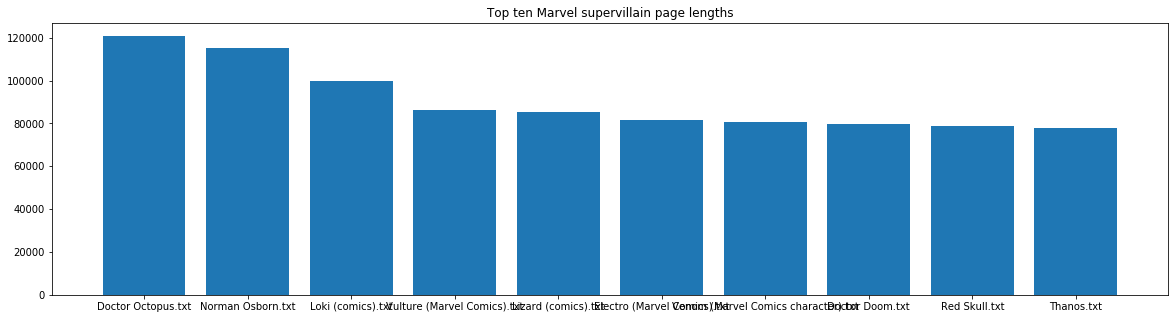

the top 10 heroes with the longest wikipedia pages are: 
	 Spider-Man
	 Namor
	 Psylocke
	 Iron Man
	 Black Panther (comics)
	 Captain America
	 Hulk
	 Cyclops (Marvel Comics)
	 Thor (Marvel Comics)
	 Wolverine (character)
the top 10 ambiguous characters with the longest wikipedia pages are: 
	 Eddie Brock
	 Phoenix Force (comics)
	 Sabretooth (comics)
	 Emma Frost
	 Rogue (comics)
	 Ben Reilly
	 Magneto (comics)
	 Sandman (Marvel Comics)
	 Mystique (comics)
	 Harry Osborn


In [189]:
import numpy as np

def find_lengths(folder):
    lengths = []
    for character in listdir(folder + '/'):
        length = extract_char(folder + '/' + character)
        lengths.append([character, length])
    
    return lengths

def find_top_ten_villains():
    lengths = find_lengths('villains')
    lengths = np.array(lengths, dtype=object)    
    
    # indices of sort
    args = np.argsort(lengths[:,1], -1)[::-1]
    
    topten = lengths[args][:10]
    
    print('the top 10 villains with the longest wikipedia pages are: ')
    for villain in topten[:,0]:
        print('\t %s' % re.sub('.txt','',villain))
        
    plt.figure(figsize=(20,5))
    plt.title('Top ten Marvel supervillain page lengths')
    plt.ylabel('Page length')
    plt.xlabel('Supervillain')
    plt.bar(topten[:,0], topten[:,1])
    plt.show()
    
        
def find_top_ten_heroes():
    lengths = find_lengths('heroes')
    lengths = np.array(lengths, dtype=object)    
    
    # indices of sort
    args = np.argsort(lengths[:,1], -1)[::-1]
    
    topten = lengths[args][:10]
    
    print('the top 10 heroes with the longest wikipedia pages are: ')
    for hero in topten[:,0]:
        print('\t %s' % re.sub('.txt','',hero))
        
    plt.figure(figsize=(20,5))
    plt.title('Top ten Marvel superhero page lengths')
    plt.ylabel('Page length')
    plt.xlabel('Superhero')
    plt.bar(topten[:,0], topten[:,1])
    plt.show()
        
                       
def find_top_ten_ambiguous():
    lengths = find_lengths('ambiguous')
    lengths = np.array(lengths, dtype=object)    
    
    # indices of sort
    args = np.argsort(lengths[:,1], -1)[::-1]
    
    topten = lengths[args][:10]
    
    print('the top 10 ambiguous characters with the longest wikipedia pages are: ')
    for ambi in topten[:,0]:
        print('\t %s' % re.sub('.txt','',ambi))      

find_top_ten_villains()
find_top_ten_heroes()
find_top_ten_ambiguous()

#### Timeline

>**Ex. 3.2.3**: We are interested in knowing if there is a time-trend in the debut of characters.
* Extract into three lists, debut years of heroes, villains, and ambiguous characters.
* Do all pages have a debut year? Do some have multiple? How do you handle these inconsistencies?
* For each class, visualize the amount of characters introduced over time. You choose how you want to visualize this data, but please comment on your choice. Also comment on the outcome of your analysis.

>*Hint: The debut year is given on the debut row in the info table of a character's Wiki-page. There are many ways that you can extract this variable. You should try to have a go at it yourself, but if you are short on time, you can use this horribly ugly regular expression code:*

>*`re.findall(r"\d{4}\)", re.findall(r"debut.+?\n", markup_text)[0])[0][:-1]`*

#### Alliances

>**Ex. 3.2.4**: In this exercise you want to find out what the biggest alliances in the Marvel universe are. The data you need for doing this is in the *alliances*-field of the markup of each character. Below I suggest steps you can take to solve the problem if you get stuck.
* Write a regex that extracts the *alliances*-field of a character's markup.
* Write a regex that extracts each team from the *alliance*-field.
* Count the number of members for each team (hint: use a `defaultdict`).
* Inspect your team names. Are there any that result from inconsistencies in the information on the pages? How do you deal with this?
* **Print the 10 largest alliances and their number of members.**